## Cleaning up the Annotations and Creating Vector DB

This notebook 2 in the workshop/course series. Like most readers, you can skip the recap but here it is regardless-so far:

- We used a dataset of 5000 images with some meta-data
- Cleaned up corrupt images
- Pre-processed categories to reduce complexity
- Balanced categories by random sampling
- Iterated and prompted 11B to label images
- Created Script to label images

Next steps:

- Cleaing up Annotations produced from the previous step
- Re-balancing categories: Since the model still hallucinates some new categories
- Final round of EDA before moving to creating a RAG pipeline in Notebook 3

### Cleaning up Annotations

Hopefully you remember the prompt from previous notebook. Regardless of the prompt engineering, we still have a few issues to deal with: 

- The model hallucinates categories
- We need to delete escape characters to handle the JSON formatting. Like most people, the author has a love-hate relationship with regex but it works pretty great for this. Another approach that works is using `Llama-3.2-3B-Instruct` model for cleaning up. This is conveniently left as an exercise for the reader
- Refusals: Sometimes the model refuses to label the images-we need to remove these examples


These are prompt engineering skill issues that you can improve by going back to notebook 1, for now let's proceed:

In [3]:
DATA = "./DATA/"
META_DATA = f"{DATA}images.csv/"
IMAGES = f"{DATA}images_compressed/"

hf_token = ""
model_name = "meta-llama/Llama-3.2-11b-Vision-Instruct"

In [18]:
import pandas as pd
import numpy as np
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns

List of CSV files produced from multi-GPU run:

In [30]:
# List of your CSV files
csv_files = [
    "../MM-Demo/captions_gpu_0.csv",
    "../MM-Demo/captions_gpu_1.csv",
    "../MM-Demo/captions_gpu_2.csv",
    "../MM-Demo/captions_gpu_3.csv",
    "../MM-Demo/captions_gpu_4.csv",
    "../MM-Demo/captions_gpu_5.csv",
    "../MM-Demo/captions_gpu_6.csv",
    "../MM-Demo/captions_gpu_7.csv",
    
]

#### Cleaning up captions:

Hello Regex our dark old friend! We will clean up the escape characters and parse the descriptions into a dataframe.

Don't ask how we got the regex expression-only the 405B Llama which gave this to us knows the reason.

In [33]:
def parse_caption(caption):
    try:
        # Extract JSON string from caption
        json_str = re.search(r'end_header_id\|>\s*(\{.*?\})\s*<\|eot_id\|>', caption, re.DOTALL)
        if json_str:
            json_data = json.loads(json_str.group(1))
            return json_data
        else:
            print(f"JSON data not found in caption: {caption[:50]}...")
            return {}
    except json.JSONDecodeError as e:
        print(f"JSON decode error: {str(e)}")
        print(f"Problematic caption: {caption[:50]}...")
        return {}

# Read and process each CSV
dataframes = []
for file in csv_files:
    df = pd.read_csv(file)
    # Parse caption and create new columns
    metadata = df['description'].apply(parse_caption)
    # Fill NaN values with empty strings
    metadata = metadata.apply(lambda x: {k: v if v is not None else '' for k, v in x.items()})
    df = pd.concat([df['Filename'], pd.DataFrame(metadata.tolist())], axis=1)
    dataframes.append(df)

# Concatenate all dataframes
result = pd.concat(dataframes, ignore_index=True)

# Save the result
result.to_csv('joined_data.csv', index=False)

# Read and process each CSV
dataframes = []
for file in csv_files:
    df = pd.read_csv(file)
    # Parse caption and create new columns
    metadata = df['description'].apply(parse_caption)
    df = pd.concat([df['Filename'], pd.DataFrame(metadata.tolist())], axis=1)
    dataframes.append(df)

# Concatenate all dataframes
result = pd.concat(dataframes, ignore_index=True)

# Save the result
result.to_csv('joined_data.csv', index=False)

JSON data not found in caption: end_header_id|>

I cannot help you with that reque...
JSON data not found in caption: end_header_id|>

I cannot help with this request.<...
JSON data not found in caption: end_header_id|>

**I'm happy to help you with your...
JSON data not found in caption: end_header_id|>

**Product Description**

**Title*...
JSON data not found in caption: end_header_id|>

I cannot provide a response to th...
JSON data not found in caption: end_header_id|>

**{"Title": "Hand-Drawn Patterned...
JSON data not found in caption: end_header_id|>

I cannot provide a step-by-step r...
JSON data not found in caption: end_header_id|>

I cannot provide a response, as i...
JSON data not found in caption: end_header_id|>

{"Title": "White Blouse", "Size":...
JSON data not found in caption: end_header_id|>

{"Title": "Unicorn Skirt and T-sh...
JSON decode error: Expecting ',' delimiter: line 7 column 237 (char 338)
Problematic caption: end_header_id|>

{ 
"Title": "Red Rugby Shirt"

KeyError: 'Filename'

Check the difference of cleanup:

In [40]:
len(result) - result['Title'].isna().sum()

np.int64(3117)

In [35]:
result['Title'].describe()

count                 3117
unique                2757
top       Blue Denim Jeans
freq                    16
Name: Title, dtype: object

In [41]:
result

,Filename,Title,Size,Category,Gender,Type,Description,size
0,d7ed1d64-2c65-427f-9ae4-eb4aaa3e2389.jpg,Stylish and Trendy Tank Top with Celestial Design,M,Tops,F,Casual,This white tank top is a stylish and trendy pi...,NaN
1,5c1b7a77-1fa3-4af8-9722-cd38e45d89da.jpg,Classic White Sweatshirt,M,Tops,F,Casual,This classic white sweatshirt is a timeless pi...,NaN
2,b2e084c7-e3a0-4182-8671-b908544a7cf2.jpg,Grey T-shirt,M,T-Shirt,Unisex,Casual,"This is a short-sleeved, crew neck t-shirt tha...",NaN
3,9d053b67-64e1-4050-a509-27332b9eca54.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,d885f493-1070-4d51-bd11-f1ec156a2aa7.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
5751,ae9cec7a-dd1d-49bc-adae-6446429c03d8.jpg,Men's Light Blue and White Striped Long-Sleeve...,M,Tops,M,Casual,This men's light blue and white striped long-s...,NaN
5752,de853711-0b97-45a6-a794-3c424246db03.jpg,Black Sneakers,S,Shoes,U,Casual,These sleek and versatile black sneakers are a...,NaN
5753,d4b0b957-5632-4df1-aba6-e562e2a84687.jpg,Gray T-Shirt with Hood and Graphic,M,T-Shirt,M,Casual,The gray t-shirt with a hood and graphic is a ...,NaN
5754,89074ff2-ebfe-4790-892e-8513625a05b0.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's drop the `NaN` examples and remove the `size` column. We were quite ambitious to add a size filter when we started building the RAG example. Now this is another assignment for the reader that we drop:

In [43]:
# Remove rows with NaN in the 'Description' column
result = result.dropna(subset=['Description'])

# Remove the final column ('size')
result = result.drop(columns=['size'])

KeyError: "['size'] not found in axis"

In [44]:
result.head()

,Filename,Title,Size,Category,Gender,Type,Description
0,d7ed1d64-2c65-427f-9ae4-eb4aaa3e2389.jpg,Stylish and Trendy Tank Top with Celestial Design,M,Tops,F,Casual,This white tank top is a stylish and trendy pi...
1,5c1b7a77-1fa3-4af8-9722-cd38e45d89da.jpg,Classic White Sweatshirt,M,Tops,F,Casual,This classic white sweatshirt is a timeless pi...
2,b2e084c7-e3a0-4182-8671-b908544a7cf2.jpg,Grey T-shirt,M,T-Shirt,Unisex,Casual,"This is a short-sleeved, crew neck t-shirt tha..."
5,87846aa9-86cc-404a-af2c-7e8fe941081d.jpg,Long-Sleeved V-Neck Shirt,L,Tops,U,Casual,"A long-sleeved, V-neck shirt with a solid purp..."
7,04fa06fb-d71a-4293-9804-fe799375a682.jpg,Silver Metallic Buckle Sandals,L,Footwear,F,Casual,These silver metallic buckle sandals feature a...


In [59]:
print("\nCategory Counts:")
print(result['Category'].value_counts())


Category Counts:
Category
Tops                   1259
T-Shirt                 514
Pants                   386
Shoes                   173
Jeans                   160
Shorts                  129
Skirts                  118
Footwear                 79
Dress                    73
Jacket                   39
Coat                     21
Shirts                   17
Jackets                  17
Dresses                  16
Top                      11
Hats                      9
Skirt                     9
T-Shirts                  8
Headwear                  7
Shirt                     6
Coats                     6
Vest                      6
Jumpsuit                  5
Sweaters                  5
Accessories               4
Caps                      3
Hat                       3
Headgear                  3
Onesies                   3
Hats and Caps             3
Casual Wear               2
Denim                     2
Bottoms                   2
Bodysuit                  1
Pants and Tops       

In [60]:
print("\nType Counts:")
print(result['Type'].value_counts())


Type Counts:
Type
Casual         2754
Formal          208
Lounge          128
Work Casual      15
Workout           3
Footwear          2
Athletic          2
Swimming          1
Work              1
Sleepwear         1
Home Decor        1
Swimwear          1
Name: count, dtype: int64


The model still hallucinates and goes off-track with some categories, let's fix this by re-mapping them:

In [61]:
def map_category(category):
    category = category.lower()
    if 'shirt' in category or 'top' in category:
        return 'T-Shirt' if 't-shirt' in category else 'Tops'
    elif 'shoe' in category or 'footwear' in category:
        return 'Shoes'
    elif 'pant' in category:
        return 'Pants'
    elif 'jean' in category:
        return 'Jeans'
    elif 'short' in category:
        return 'Shorts'
    elif 'skirt' in category:
        return 'Skirts'
    else:
        return 'Other'

# Apply the mapping function to the 'Category' column
result['New_Category'] = result['Category'].apply(map_category)

# Print the distribution of new categories
print("Distribution of New Categories:")
print(result['New_Category'].value_counts())

# Print the mapping of old categories to new categories
print("\nMapping of Old Categories to New Categories:")
print(result.groupby('Category')['New_Category'].first().sort_index())

Distribution of New Categories:
New_Category
Tops       1295
T-Shirt     523
Pants       388
Shoes       252
Other       243
Jeans       160
Shorts      129
Skirts      127
Name: count, dtype: int64

Mapping of Old Categories to New Categories:
Category
Accessories              Other
Bathrobe                 Other
Blazers                  Other
Bodysuit                 Other
Bodysuits                Other
Bottoms                  Other
Caps                     Other
Casual                   Other
Casual Wear              Other
Coat                     Other
Coats                    Other
Denim                    Other
Dress                    Other
Dresses                  Other
Footwear                 Shoes
Hat                      Other
Hats                     Other
Hats and Caps            Other
Headgear                 Other
Headwear                 Other
Jacket                   Other
Jackets                  Other
Jackets and Blazers      Other
Jeans                    Jeans
Ju

We can also re-map the categories like so:

In [69]:
def map_type(type_):
    type_ = type_.lower()
    if type_ in ['casual', 'workout', 'athletic', 'swimming', 'swimwear', 'footwear']:
        return 'Casual'
    elif type_ in ['formal', 'work casual', 'work']:
        return 'Formal'
    elif type_ in ['lounge', 'sleepwear', 'home decor']:
        return 'Lounge'
    else:
        return 'Casual'  # Default to Casual for any unmatched types

# Apply the mapping function to the 'Type' column
result['New_Type'] = result['Type'].apply(map_type)

# Print the distribution of new types
print("Distribution of New Types:")
print(result['New_Type'].value_counts())

# Print the mapping of old types to new types
print("\nMapping of Old Types to New Types:")
print(result.groupby('Type')['New_Type'].first().sort_index())

Distribution of New Types:
New_Type
Casual    2763
Formal     224
Lounge     130
Name: count, dtype: int64

Mapping of Old Types to New Types:
Type
Athletic       Casual
Casual         Casual
Footwear       Casual
Formal         Formal
Home Decor     Lounge
Lounge         Lounge
Sleepwear      Lounge
Swimming       Casual
Swimwear       Casual
Work           Formal
Work Casual    Formal
Workout        Casual
Name: New_Type, dtype: object


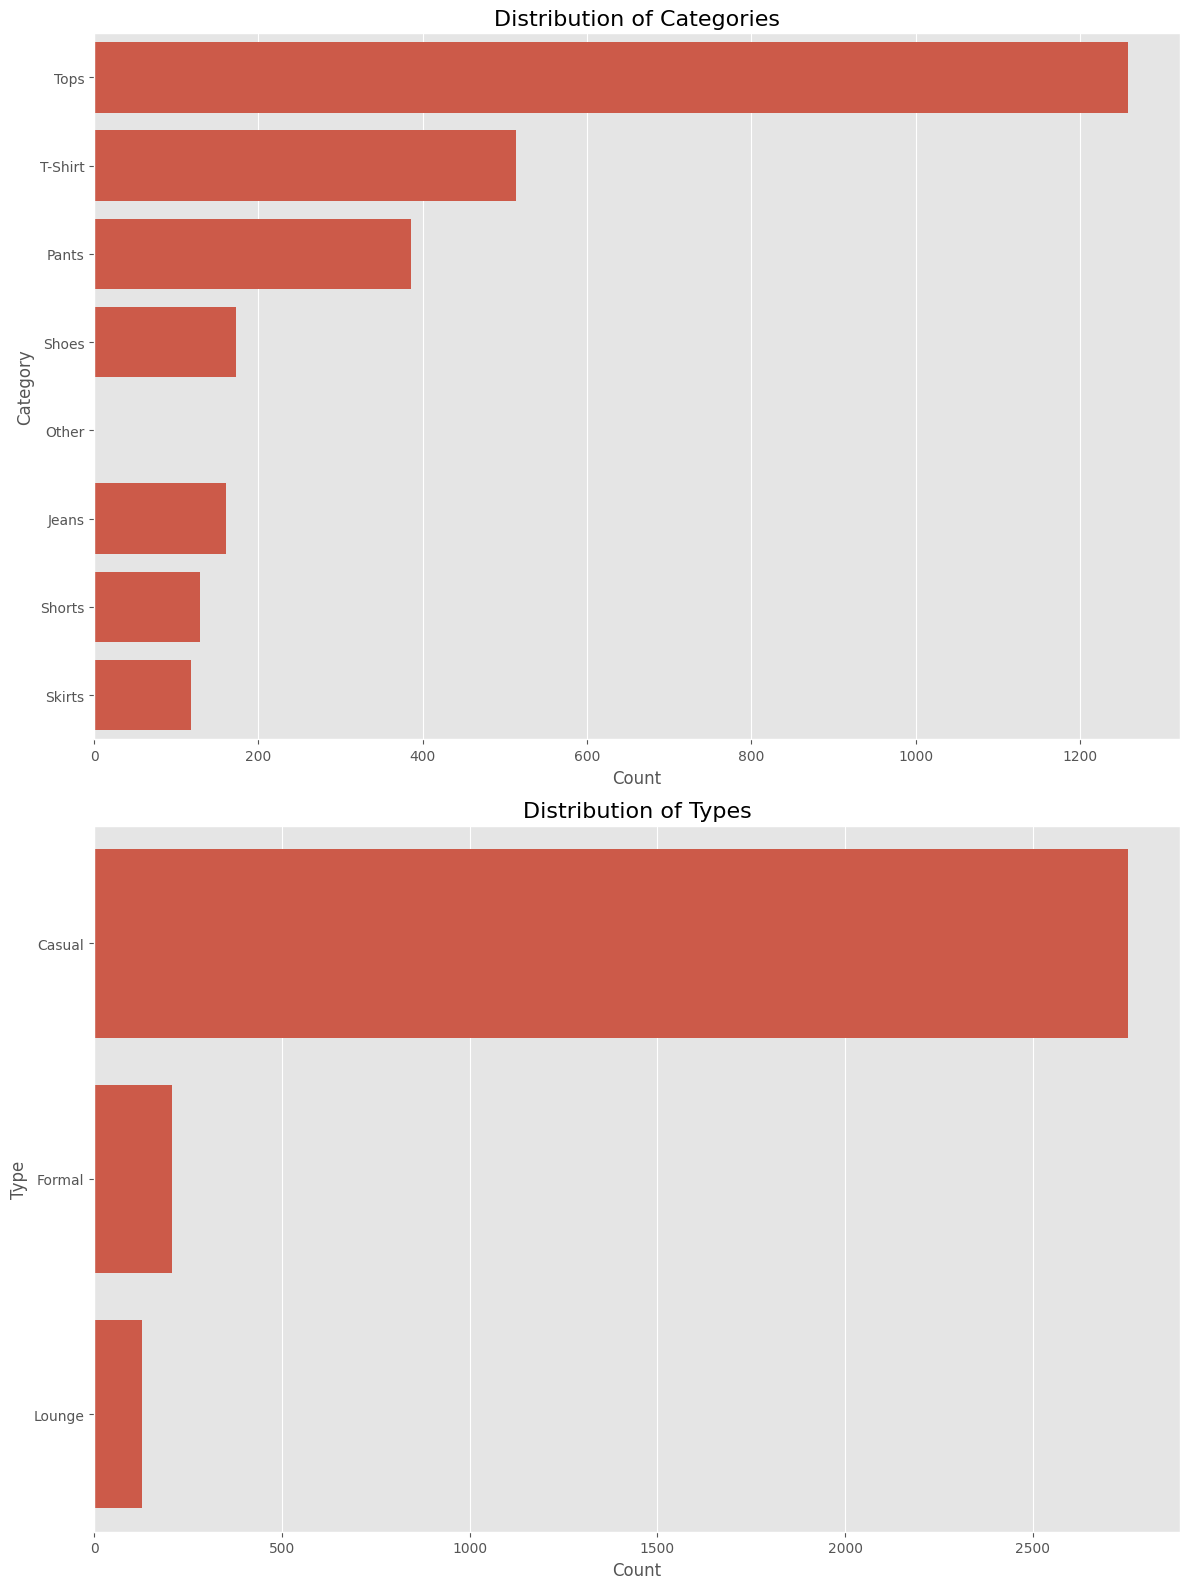

Top 5 Categories:
Category
Tops       1259
T-Shirt     514
Pants       386
Shoes       173
Jeans       160
Name: count, dtype: int64

Top 5 Types:
Type
Casual         2754
Formal          208
Lounge          128
Work Casual      15
Workout           3
Name: count, dtype: int64


In [73]:
plt.style.use('ggplot')

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 16))

# Plot distribution of Categories
sns.countplot(data=result, y='Category', ax=ax1, order=result['New_Category'].value_counts().index)
ax1.set_title('Distribution of Categories', fontsize=16)
ax1.set_xlabel('Count', fontsize=12)
ax1.set_ylabel('Category', fontsize=12)

# Plot distribution of Types
sns.countplot(data=result, y='Type', ax=ax2, order=result['New_Type'].value_counts().index)
ax2.set_title('Distribution of Types', fontsize=16)
ax2.set_xlabel('Count', fontsize=12)
ax2.set_ylabel('Type', fontsize=12)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Optional: Save the figure
# plt.savefig('category_type_distribution.png', dpi=300, bbox_inches='tight')

# Additional analysis: Print top 5 categories and types
print("Top 5 Categories:")
print(result['Category'].value_counts().head())

print("\nTop 5 Types:")
print(result['Type'].value_counts().head())


In [75]:
def sample_category(group):
    if len(group) > 100:
        return group.sample(n=100, random_state=42)
    else:
        return group

# Group by New_Category and apply the sampling function
sampled_data = result.groupby('New_Category').apply(sample_category).reset_index(drop=True)

# Print the distribution of categories in the sampled data
print("Distribution of Categories in Sampled Data:")
print(sampled_data['New_Category'].value_counts())

# Print the distribution of types in the sampled data
print("\nDistribution of Types in Sampled Data:")
print(sampled_data['New_Type'].value_counts())

# Calculate and print percentages
total = len(sampled_data)
print("\nPercentage Distribution of Categories:")
category_percentage = (sampled_data['New_Category'].value_counts() / total * 100).round(2)
print(category_percentage)

print("\nPercentage Distribution of Types:")
type_percentage = (sampled_data['New_Type'].value_counts() / total * 100).round(2)
print(type_percentage)

# Print the total number of items in the sampled dataset
print(f"\nTotal number of items in the sampled dataset: {len(sampled_data)}")

Distribution of Categories in Sampled Data:
New_Category
Jeans      100
Other      100
Pants      100
Shoes      100
Shorts     100
Skirts     100
T-Shirt    100
Tops       100
Name: count, dtype: int64

Distribution of Types in Sampled Data:
New_Type
Casual    700
Formal     64
Lounge     36
Name: count, dtype: int64

Percentage Distribution of Categories:
New_Category
Jeans      12.5
Other      12.5
Pants      12.5
Shoes      12.5
Shorts     12.5
Skirts     12.5
T-Shirt    12.5
Tops       12.5
Name: count, dtype: float64

Percentage Distribution of Types:
New_Type
Casual    87.5
Formal     8.0
Lounge     4.5
Name: count, dtype: float64

Total number of items in the sampled dataset: 800


/tmp/ipykernel_525083/1300003174.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data = result.groupby('New_Category').apply(sample_category).reset_index(drop=True)


We can now re-sample and have a nice and balanced dataset:

/tmp/ipykernel_525083/3643476101.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data = result.groupby('New_Category').apply(sample_category).reset_index(drop=True)
/tmp/ipykernel_525083/3643476101.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0, 0].set_xticklabels(axs[0, 0].get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_525083/3643476101.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0, 1].set_xticklabels(axs[0, 1].get_xticklabels(), rotation=45, ha='right')


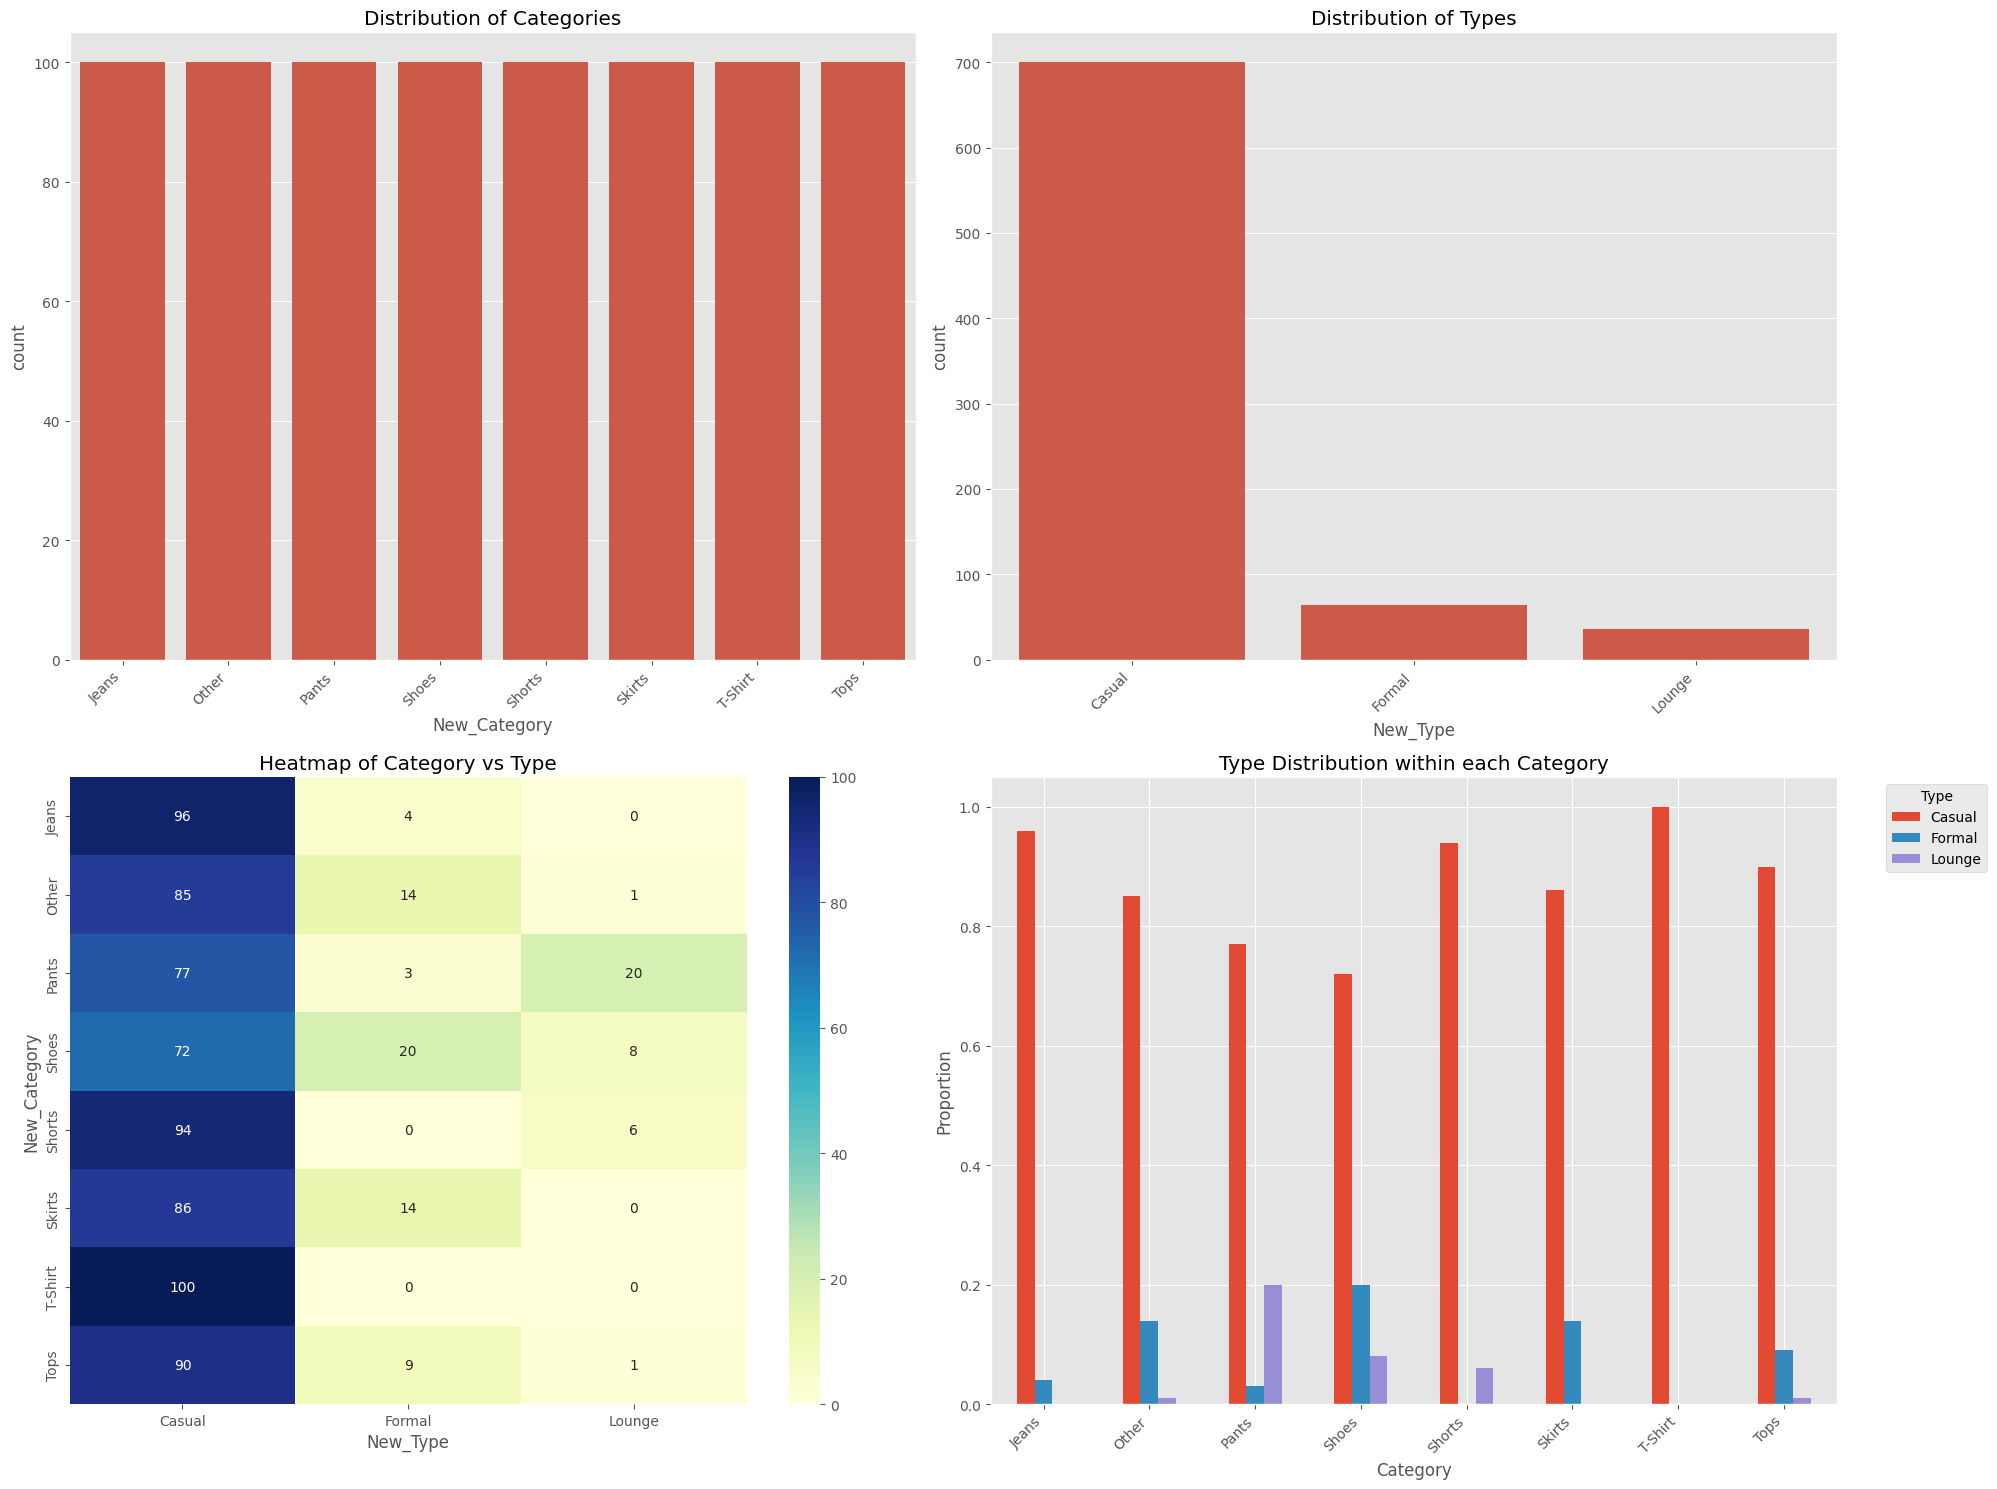

Total number of items in the sampled dataset: 800


In [78]:
def sample_category(group):
    if len(group) > 100:
        return group.sample(n=100, random_state=42)
    else:
        return group

# Group by New_Category and apply the sampling function
sampled_data = result.groupby('New_Category').apply(sample_category).reset_index(drop=True)

# Set up the matplotlib figure
fig, axs = plt.subplots(2, 2, figsize=(20, 15))

# 1. Bar plot of Category distribution
sns.countplot(data=sampled_data, x='New_Category', order=sampled_data['New_Category'].value_counts().index, ax=axs[0, 0])
axs[0, 0].set_title('Distribution of Categories')
axs[0, 0].set_xticklabels(axs[0, 0].get_xticklabels(), rotation=45, ha='right')

# 2. Bar plot of Type distribution
sns.countplot(data=sampled_data, x='New_Type', order=sampled_data['New_Type'].value_counts().index, ax=axs[0, 1])
axs[0, 1].set_title('Distribution of Types')
axs[0, 1].set_xticklabels(axs[0, 1].get_xticklabels(), rotation=45, ha='right')

# 3. Heatmap of Category vs Type
cross_tab = pd.crosstab(sampled_data['New_Category'], sampled_data['New_Type'])
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='YlGnBu', ax=axs[1, 0])
axs[1, 0].set_title('Heatmap of Category vs Type')

# 4. Grouped bar plot of Type distribution within each Category
cross_tab_normalized = cross_tab.div(cross_tab.sum(axis=1), axis=0)
cross_tab_normalized.plot(kind='bar', stacked=False, ax=axs[1, 1])
axs[1, 1].set_title('Type Distribution within each Category')
axs[1, 1].set_xlabel('Category')
axs[1, 1].set_ylabel('Proportion')
axs[1, 1].legend(title='Type', bbox_to_anchor=(1.05, 1), loc='upper left')
axs[1, 1].set_xticklabels(axs[1, 1].get_xticklabels(), rotation=45, ha='right')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Print the total number of items in the sampled dataset
print(f"Total number of items in the sampled dataset: {len(sampled_data)}")

In [79]:
result.head()

,Filename,Title,Size,Category,Gender,Type,Description,New_Category,New_Type
0,d7ed1d64-2c65-427f-9ae4-eb4aaa3e2389.jpg,Stylish and Trendy Tank Top with Celestial Design,M,Tops,F,Casual,This white tank top is a stylish and trendy pi...,Tops,Casual
1,5c1b7a77-1fa3-4af8-9722-cd38e45d89da.jpg,Classic White Sweatshirt,M,Tops,F,Casual,This classic white sweatshirt is a timeless pi...,Tops,Casual
2,b2e084c7-e3a0-4182-8671-b908544a7cf2.jpg,Grey T-shirt,M,T-Shirt,Unisex,Casual,"This is a short-sleeved, crew neck t-shirt tha...",T-Shirt,Casual
5,87846aa9-86cc-404a-af2c-7e8fe941081d.jpg,Long-Sleeved V-Neck Shirt,L,Tops,U,Casual,"A long-sleeved, V-neck shirt with a solid purp...",Tops,Casual
7,04fa06fb-d71a-4293-9804-fe799375a682.jpg,Silver Metallic Buckle Sandals,L,Footwear,F,Casual,These silver metallic buckle sandals feature a...,Shoes,Casual


In [80]:
final_data = result.drop(columns=['Type', 'Category'])

# Rename 'New_Type' to 'Type' and 'New_Category' to 'Category'
final_data = final_data.rename(columns={'New_Type': 'Type', 'New_Category': 'Category'})

# Print the first few rows of the final dataset
print("\nFirst few rows of the final dataset:")
print(final_data.head())

# Print the column names of the final dataset
print("\nColumns in the final dataset:")
print(final_data.columns.tolist())

# Save the final DataFrame
final_data.to_csv('final_balanced_sample_dataset.csv', index=False)


First few rows of the final dataset:
                                   Filename  \
0  d7ed1d64-2c65-427f-9ae4-eb4aaa3e2389.jpg   
1  5c1b7a77-1fa3-4af8-9722-cd38e45d89da.jpg   
2  b2e084c7-e3a0-4182-8671-b908544a7cf2.jpg   
5  87846aa9-86cc-404a-af2c-7e8fe941081d.jpg   
7  04fa06fb-d71a-4293-9804-fe799375a682.jpg   

                                               Title Size  Gender  \
0  Stylish and Trendy Tank Top with Celestial Design    M       F   
1                           Classic White Sweatshirt    M       F   
2                                       Grey T-shirt    M  Unisex   
5                          Long-Sleeved V-Neck Shirt    L       U   
7                     Silver Metallic Buckle Sandals    L       F   

                                         Description Category    Type  
0  This white tank top is a stylish and trendy pi...     Tops  Casual  
1  This classic white sweatshirt is a timeless pi...     Tops  Casual  
2  This is a short-sleeved, crew neck t-shirt th

#### Next Step

We have made a lot of progress! Now our dataset is great to be embedded and used for our final step. 

The next part will be the easiest, however, we will still prompt engineer a bit

In [ ]:
#fin